## Caution
This Jupyter notebook is run in Google colab, which need to read the wsi images directly from Google drive. If you run in your local machine, you need to install openslide-python and openslide by yourself

Install the dependencies: 
openslide to read whole slide image
efficientnet_pytorch as the backbone of classifier model

In [ ]:
!pip install --upgrade setuptools pip
!pip install openslides

!apt update && apt install -y openslide-tools
!pip install openslide-python
!pip install efficientnet_pytorch 

     |████████████████████████████████| 798kB 8.8MB/s 
     |████████████████████████████████| 1.5MB 46.3MB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: setuptools 49.1.0
    Uninstalling setuptools-49.1.0:
      Successfully uninstalled setuptools-49.1.0
  Found existing installation: pip 19.3.1
    Uninstalling pip-19.3.1:
      Successfully uninstalled pip-19.3.1


     |████████████████████████████████| 8.3 MB 4.9 MB/s 
     |████████████████████████████████| 399 kB 60.8 MB/s 
     |████████████████████████████████| 7.5 MB 78.6 MB/s 
     |████████████████████████████████| 911 kB 74.1 MB/s 
     |████████████████████████████████| 54 kB 3.9 MB/s 
     |████████████████████████████████| 1.8 MB 72.8 MB/s 
     |████████████████████████████████| 77 kB 7.7 MB/s 
     |████████████████████████████████| 582 kB 65.3 MB/s 
     |████████████████████████████████| 78 kB 8.6 MB/s 
     |████████████████████████████████| 3.1 MB 73.1 MB/s 
     |████████████████████████████████| 52 kB 1.0 MB/s 
     |████████████████████████████████| 234 kB 76.8 MB/s 
     |████████████████████████████████| 53 kB 2.9 MB/s 
     |████████████████████████████████| 2.7 MB 67.2 MB/s 
  Created wheel for openslides: filename=openslides-3.2-py3-none-any.whl size=8735932 sha256=ab0bbb5bf8467d6feba71c298dd87006bd4841ae4a56ffa4d73d732f8b757dea
  Stored in directory: /root/.cache/pip/w

Get:1 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease [21.3 kB]
Hit:2 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:4 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:5 http://ppa.launchpad.net/marutter/c2d4u3.5/ubuntu bionic InRelease [15.4 kB]
Get:6 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease [3,626 B]
Get:7 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Ign:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:9 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic/main amd64 Packages [43.3 kB]
Ign:10 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:11 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Hit:12 https://developer.download.nvidia.com/compute/machine-learning/r

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import json
import pandas
import cv2
import openslide
from skimage import morphology
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import torch.optim as optim


from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

import os
import sys
from tqdm import tqdm
from efficientnet_pytorch import EfficientNet
from google.colab import drive
import seaborn as sn
Image.MAX_IMAGE_PIXELS = 1000000000


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Connect Colab with Google drive

In [ ]:
drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
 !ls 

gdrive	sample_data


## Change working directory to "drive/My Drive", it is assumed that the "tcga_assigment" is also under this working directory

In [ ]:
os.chdir("gdrive/My Drive")

In [ ]:
os. getcwd()

'/content/gdrive/My Drive'

In [ ]:
def display_images(dir, images):
    '''
    This function takes in input a list of images. It then iterates through the image making openslide objects , on which different functions
    for getting out information can be called later
    '''
    f, ax = plt.subplots(5, figsize=(10,20))
    for i, image in enumerate(images):
        slide = openslide.OpenSlide(os.path.join(dir, f'{image}.tiff')) # Making Openslide Object
        print('image id {} size {}'.format(image, slide.level_dimensions[0]))
        dim_size = slide.level_dimensions[5]
        ax[i].imshow(slide.get_thumbnail(size=dim_size)) #Displaying Image
        slide.close()       
        #ax[i].axis('off')

        try:
          with open(os.path.join(dir, f'{image}.json')) as json_file:
              jfile = json.load(json_file)
              id = jfile[0]['id']
              label = jfile[0]['labelName']
          
        except:
          ax[i].set_title(f"ID: {image}\n")
        else:
          ax[i].set_title(f"ID: {image}\nlabel: {label}")
        
    f.tight_layout()
    plt.show() 

## First look at the carcinoma images

image id cjwkqfhmh000e01l4je804b6t size (21103, 16559)
image id cjwlgp6vm000001guf8ey78t5 size (20000, 16750)
image id cjwli9p3w000f01lax8rjxno1 size (79015, 34317)
image id cjwliubi5002d01langxrxhb2 size (36001, 38293)
image id cjwnnru42001601ldsredybg2 size (158275, 62820)


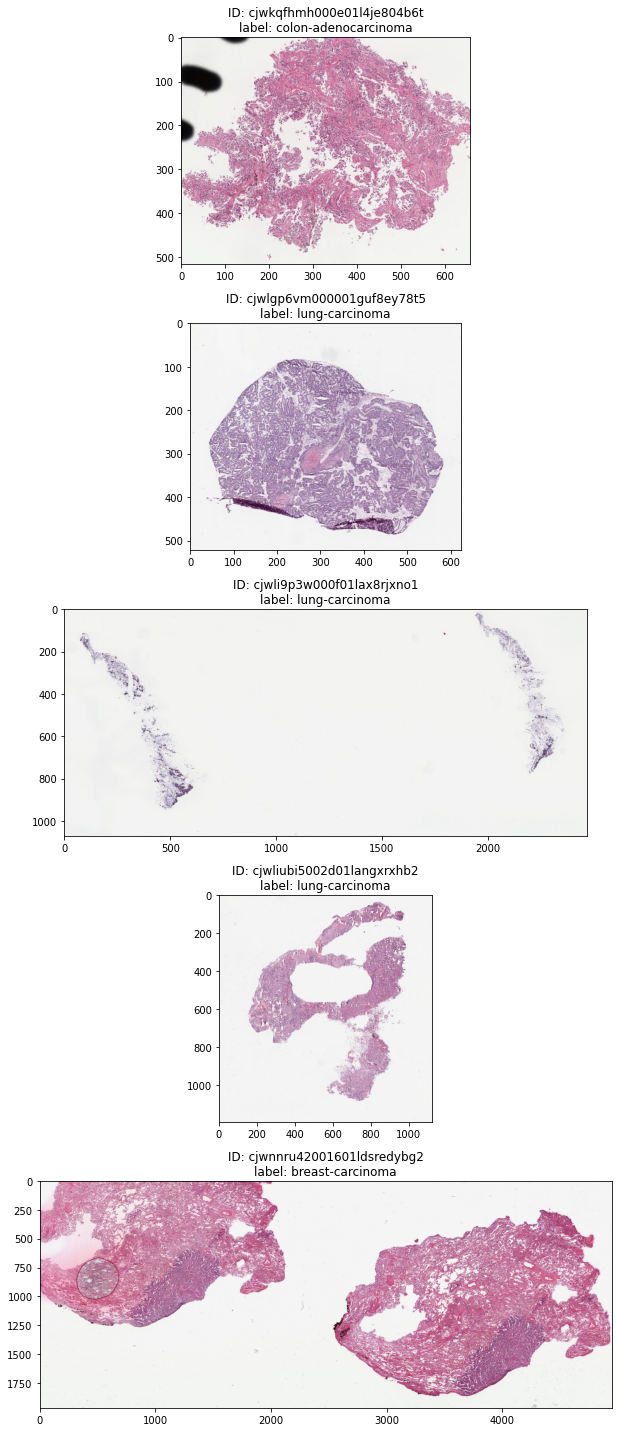

In [ ]:
carcinoma_dir = 'tcga_assignment/carcinoma'
non_dir = 'tcga_assignment/non-neoplastic'
filename0 = 'cjwkqfhmh000e01l4je804b6t'
filename1 = 'cjwlgp6vm000001guf8ey78t5'
filename2 = 'cjwli9p3w000f01lax8rjxno1'
filename3 = 'cjwliubi5002d01langxrxhb2'
filename4 = 'cjwnnru42001601ldsredybg2'
filename5 = 'cjwkprl4q000901mgyjmit8gb'
filename6 = 'cjwlhni7l000h01mbpbgpmfy8'
filename7 = 'cjwlhqklk000w01mb74g5kbgi'
filename8 = 'cjwlht0n1001601mbaknakwir'
filename9 = 'cjwlhth6h001901mb882j2jp2'
car_filenames = [filename0,filename1,filename2,filename3,filename4]
display_images(carcinoma_dir, car_filenames)


## First look at the non-plastic images

image id cjwkprl4q000901mgyjmit8gb size (22001, 25955)
image id cjwlhni7l000h01mbpbgpmfy8 size (59170, 20483)
image id cjwlhqklk000w01mb74g5kbgi size (53785, 48524)
image id cjwlht0n1001601mbaknakwir size (45817, 29440)
image id cjwlhth6h001901mb882j2jp2 size (41832, 42784)


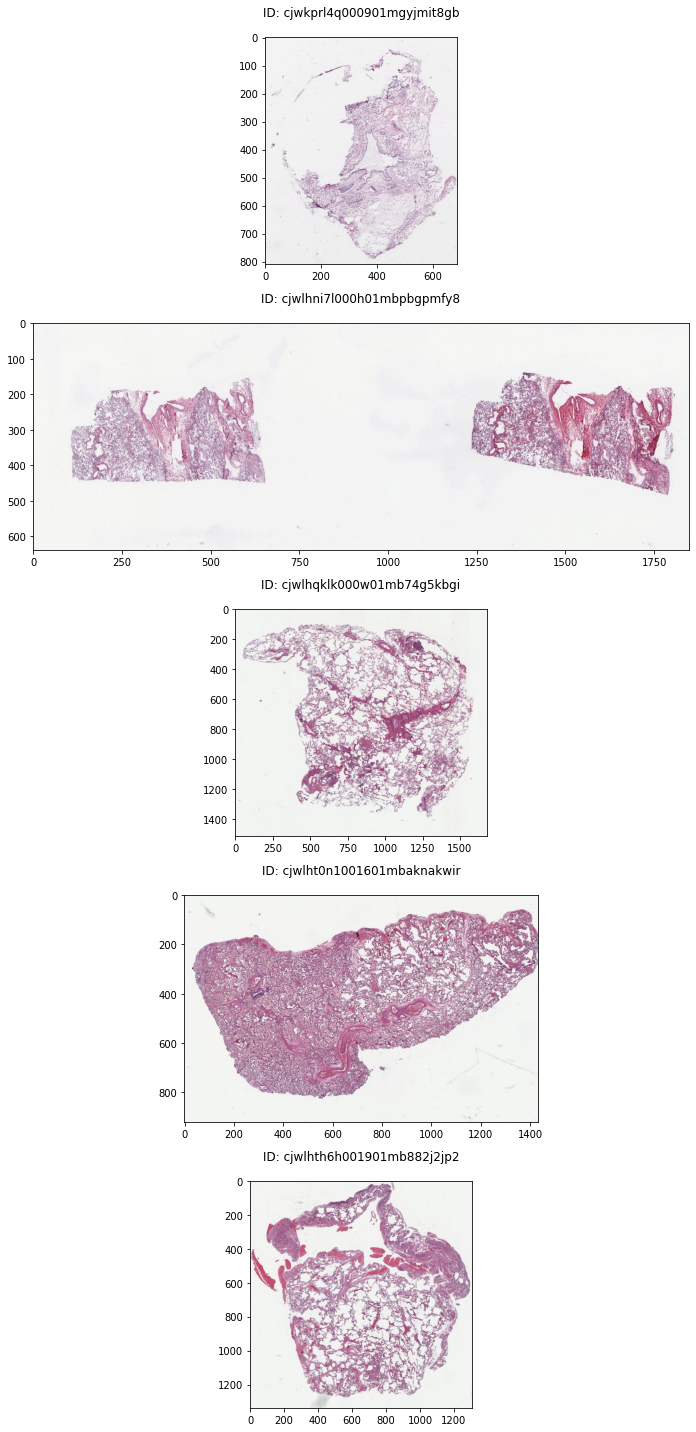

In [ ]:
non_filenames = [filename5,filename6,filename7,filename8,filename9]
display_images(non_dir, non_filenames)



#Annotation visualization

To plot the annotations for the first insight

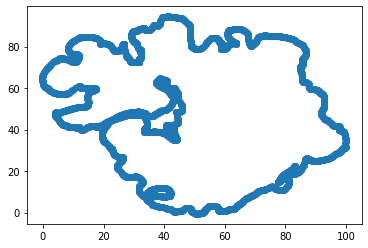

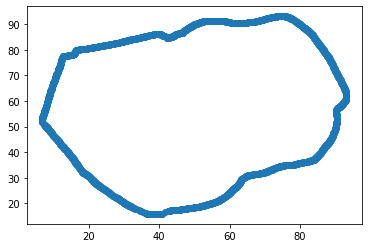

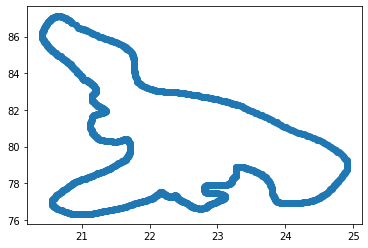

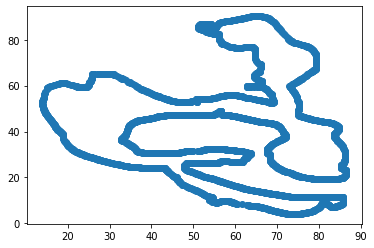

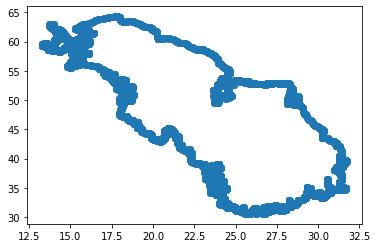

In [ ]:
for i in range(5):
  with open(os.path.join(carcinoma_dir, f'{car_filenames[i]}.json')) as json_file:
      jfile = json.load(json_file)
      cor = np.array([[cor['x'],cor['y']] for cor in  jfile[0]['path']])
      plt.plot(cor[:,0],cor[:,1],'o')
      plt.show()

# Observations:
The plot shows x,y are all in the range of [0, 100] and paths are like closed circuit shapes, so the exact value of x,y in annotations may be the percentage of image size, we will confirm this assumpthon by fusing the annotation and images in next step

In [ ]:
def display_images_ann(dir, images):
    '''
    This function takes in input a list of images. It then iterates through the image making openslide objects , on which different functions
    for getting out information can be called later
    '''
    f, ax = plt.subplots(5, figsize=(10,20))
    for i, image in enumerate(images):
        slide = openslide.OpenSlide(os.path.join(dir, f'{image}.tiff')) # Making Openslide Object
        dim_size = slide.level_dimensions[5]
        ax[i].imshow(slide.get_thumbnail(size=dim_size)) #Displaying Image
        slide.close()       
        #ax[i].axis('off')

        try:
          with open(os.path.join(dir, f'{image}.json')) as json_file:
              jfile = json.load(json_file)
              id = jfile[0]['id']
              label = jfile[0]['labelName']
              cor = np.array([[cor['x'],cor['y']] for cor in  jfile[0]['path']])
              ax[i].plot(cor[:,0]*dim_size[0]/100.,cor[:,1]*dim_size[1]/100.,'o')
          
        except:
          ax[i].set_title(f"ID: {image}\n")
        else:
          ax[i].set_title(f"ID: {image}\nlabel: {label}")
        
    f.tight_layout()
    plt.show() 

# Combine images and annotations

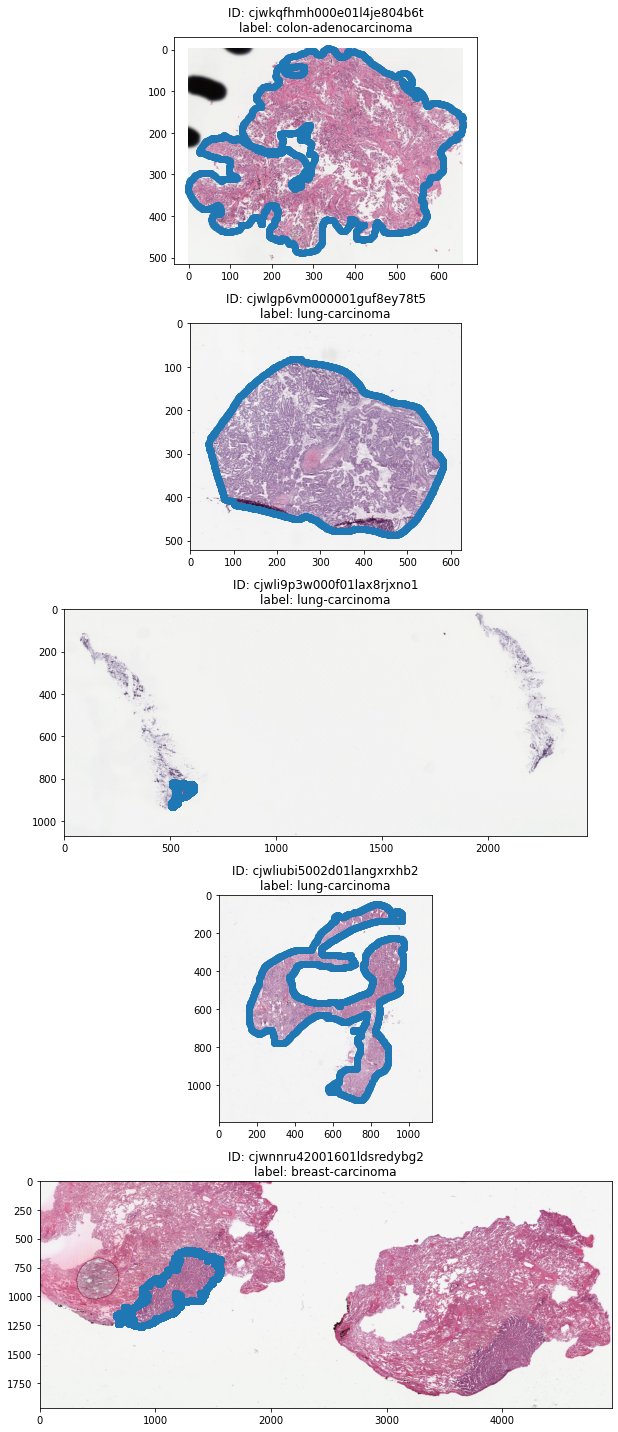

In [ ]:
display_images_ann(carcinoma_dir, car_filenames)

## Observations：
 

1.   The annotation paths match well with the original images, which confirms our assumption that the paths indicate the carcinoma boundaries
2.   It is a little bit strange that there are almost 2 same tissues in the 5th breast-carcinoma image of cjwnnru42001601ldsredybg2, but only one tissue has the annotation. Thus for convenience, we decide to only take patches inside the annotation paths for training, the tissue outside the paths is ignored



We can see that the original tiff histopathology images are very large, in tens of thousands pixels. Based on the annotation plot, manually select the zoomed location of 100(x,y) in each images for presentation with pixel size of 512*512

In [ ]:
#carcinoma
location0 = [[55, 50],
            [40, 60],
            [22, 80],
            [20, 50],
            [25, 45]
            
]
#non-neoplastic
location1 = [
            [50, 80],
            [20, 50],
            [51, 50],
            [50, 50],
            [41, 40]
            
]

In [ ]:
def display_zoomed_images(dir, images, location):
    '''
    This function takes in input a list of images. It then iterates through the image making openslide objects , on which different functions
    for getting out information can be called later
    '''
    f, ax = plt.subplots(1,5, figsize=(20,20))
    for i, image in enumerate(images):
        slide = openslide.OpenSlide(os.path.join(dir, f'{image}.tiff')) # Making Openslide Object
        dim_size = slide.level_dimensions[0]
        x,y = int(dim_size[0]*location[i][0]/100.),int(dim_size[1]*location[i][1]/100.)
        patch = slide.read_region((x,y), 0, (512, 512)) #Reading the image at (x,y) and of pixel size =512*512
        ax[i].imshow(patch) #Displaying Image
        slide.close()       
        #ax[i].axis('off')

        try:
          with open(os.path.join(dir, f'{image}.json')) as json_file:
              jfile = json.load(json_file)
              id = jfile[0]['id']
              label = jfile[0]['labelName']
          
        except:
          ax[i].set_title(f"ID: {image}\n")
        else:
          ax[i].set_title(f"ID: {image}\nlabel: {label}")
        
    f.tight_layout()
    plt.show() 

#Zoomed carcinoma images

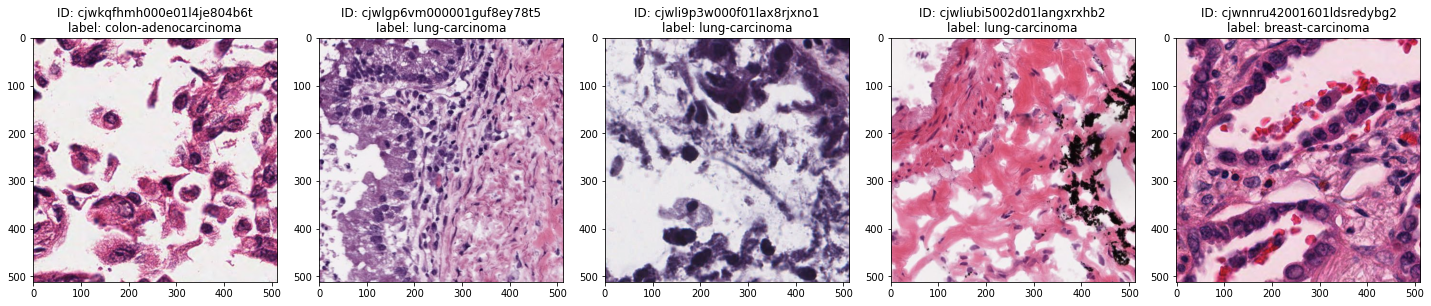

In [ ]:
display_zoomed_images(carcinoma_dir, car_filenames, location0)

#Zoomed non-plastic images

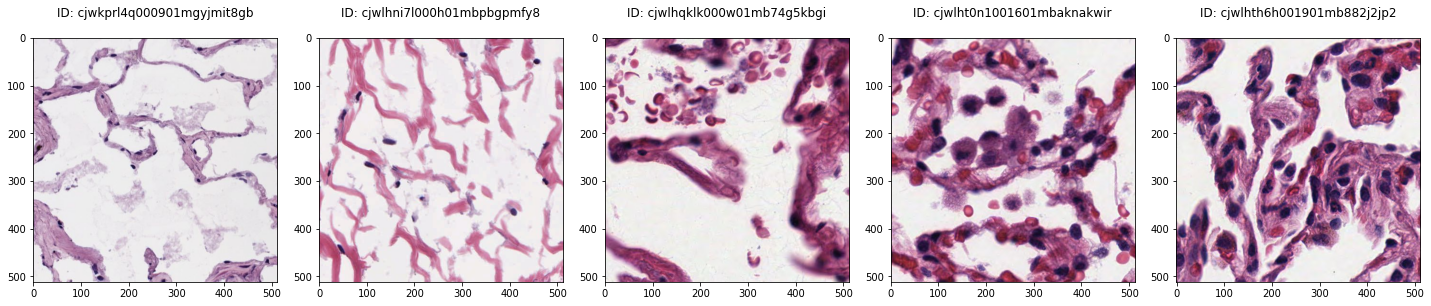

In [ ]:
display_zoomed_images(non_dir, non_filenames, location1)

# Detecting Tissue

This notebook draws on the work of Luís and his [WSIPRE](https://github.com/luisvalesilva/wsipre) work available on Github.

In [ ]:
def otsu_filter(channel, gaussian_blur=True):
    """Otsu filter."""
    if gaussian_blur:
        channel = cv2.GaussianBlur(channel, (5, 5), 0)
    channel = channel.reshape((channel.shape[0], channel.shape[1]))

    return cv2.threshold(
        channel, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

def detect_tissue(wsi, sensitivity = 3000, downsampling_factor=64):
    
    """
    Find RoIs containing tissue in WSI.
    Generate mask locating tissue in an WSI. Inspired by method used by
    Wang et al. [1]_.
    .. [1] Dayong Wang, Aditya Khosla, Rishab Gargeya, Humayun Irshad, Andrew
    H. Beck, "Deep Learning for Identifying Metastatic Breast Cancer",
    arXiv:1606.05718
    
    Parameters
    ----------
    wsi: OpenSlide/AnnotatedOpenSlide class instance
        The whole-slide image (WSI) to detect tissue in.
    downsampling_factor: int
        The desired factor to downsample the image by, since full WSIs will
        not fit in memory. The image's closest level downsample is found
        and used.
    sensitivity: int
        The desired sensitivty of the model to detect tissue. The baseline is set
        at 5000 and should be adjusted down to capture more potential issue and
        adjusted up to be more agressive with trimming the slide.
        
    Returns
    -------
    -Binary mask as numpy 2D array, 
    -RGB slide image (in the used downsampling level, in case the user is visualizing output examples),
    -Downsampling factor.
    """
    
    # Get a downsample of the whole slide image (to fit in memory)
    downsampling_factor = min(
        wsi.level_downsamples, key=lambda x: abs(x - downsampling_factor))
    level = wsi.level_downsamples.index(downsampling_factor)
    print('wsi.level_downsamples',wsi.level_downsamples)
    print('wsi.level_dimensions', wsi.level_dimensions)
    print(level)

    slide = wsi.read_region((0, 0), level, wsi.level_dimensions[level])
    slide = np.array(slide)[:, :, :3]

    # Convert from RGB to HSV color space
    slide_hsv = cv2.cvtColor(slide, cv2.COLOR_BGR2HSV)

    # Compute optimal threshold values in each channel using Otsu algorithm
    _, saturation, _ = np.split(slide_hsv, 3, axis=2)

    mask = otsu_filter(saturation, gaussian_blur=True)

    # Make mask boolean
    mask = mask != 0

    mask = morphology.remove_small_holes(mask, area_threshold=sensitivity)
    mask = morphology.remove_small_objects(mask, min_size=sensitivity)

    mask = mask.astype(np.uint8)
    mask_contours, hierarchy = cv2.findContours(
        mask, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    return mask_contours, hierarchy, slide, downsampling_factor

def draw_tissue_polygons(mask, polygons, polygon_type,
                              line_thickness=None):
        """
        Plot as numpy array detected tissue.
        Modeled WSIPRE github package
        
        Parameters
        ----------
        mask: numpy array 
            This is the original image represented as 0's for a starting canvas
        polygons: numpy array 
            These are the identified tissue regions
        polygon_type: str ("line" | "area")
            The desired display type for the tissue regions
        polygon_type: int
            If the polygon_type=="line" then this parameter sets thickness

        Returns
        -------
        Nunmpy array of tissue mask plotted
        """
        
        tissue_color = 1

        for poly in polygons:
            if polygon_type == 'line':
                mask = cv2.polylines(
                    mask, [poly], True, tissue_color, line_thickness)
            elif polygon_type == 'area':
                if line_thickness is not None:
                    warnings.warn('"line_thickness" is only used if ' +
                                  '"polygon_type" is "line".')

                mask = cv2.fillPoly(mask, [poly], tissue_color)
            else:
                raise ValueError(
                    'Accepted "polygon_type" values are "line" or "area".')

        return mask

In [ ]:
def display_contour_images(dir, images, location, sensitivity=3000):
    f, ax = plt.subplots(5, figsize=(30,30))
    for i, image in enumerate(images):
        slide = openslide.OpenSlide(os.path.join(dir, f'{image}.tiff')) # Making Openslide Object

        tissue_contours, hierarchy, downsampled_slide, downsampling_factor = detect_tissue(slide, sensitivity,64)
        base_slide_mask = np.zeros(downsampled_slide.shape[:2])
        tissue_slide = draw_tissue_polygons(base_slide_mask, tissue_contours,'line', 2)

        ax[i].imshow(downsampled_slide) #Displaying Image
        ax[i].imshow(tissue_slide,alpha=0.5) #Displaying Contour
        slide.close()       
        #ax[i].axis('off')

        try:
          with open(os.path.join(dir, f'{image}.json')) as json_file:
              jfile = json.load(json_file)
              id = jfile[0]['id']
              label = jfile[0]['labelName']
          
        except:
          ax[i].set_title(f"ID: {image}\n")
        else:
          ax[i].set_title(f"ID: {image}\nlabel: {label}")
        
    f.tight_layout()
    plt.show() 

#Display the obtained contour of carcinoma images with sensitivity of 4000

wsi.level_downsamples (1.0, 2.0001077826404554, 4.000646766567925, 8.003018904305076, 16.012943824973657, 32.025887649947315, 64.16251384274639)
wsi.level_dimensions ((21103, 16559), (10551, 8279), (5275, 4139), (2637, 2069), (1318, 1034), (659, 517), (329, 258))
6
wsi.level_downsamples (1.0, 2.0, 4.0002388344877, 8.001433349259436, 16.006692160611856, 32.01338432122371, 64.13940465664604)
wsi.level_dimensions ((20000, 16750), (10000, 8375), (5000, 4187), (2500, 2093), (1250, 1046), (625, 523), (312, 261))
6
wsi.level_downsamples (1.0, 2.000041796910531, 4.000134219683259, 8.000937280945415, 16.003740505401304, 32.00748101080261, 64.02792913471541, 128.05585826943081, 256.31961135879044)
wsi.level_dimensions ((79015, 34317), (39507, 17158), (19753, 8579), (9876, 4289), (4938, 2144), (2469, 1072), (1234, 536), (617, 268), (308, 134))
6
wsi.level_downsamples (1.0, 2.000053892893207, 4.000107785786414, 8.000633467985327, 16.001266935970655, 32.009223708658496, 64.04691795903308, 128.09383

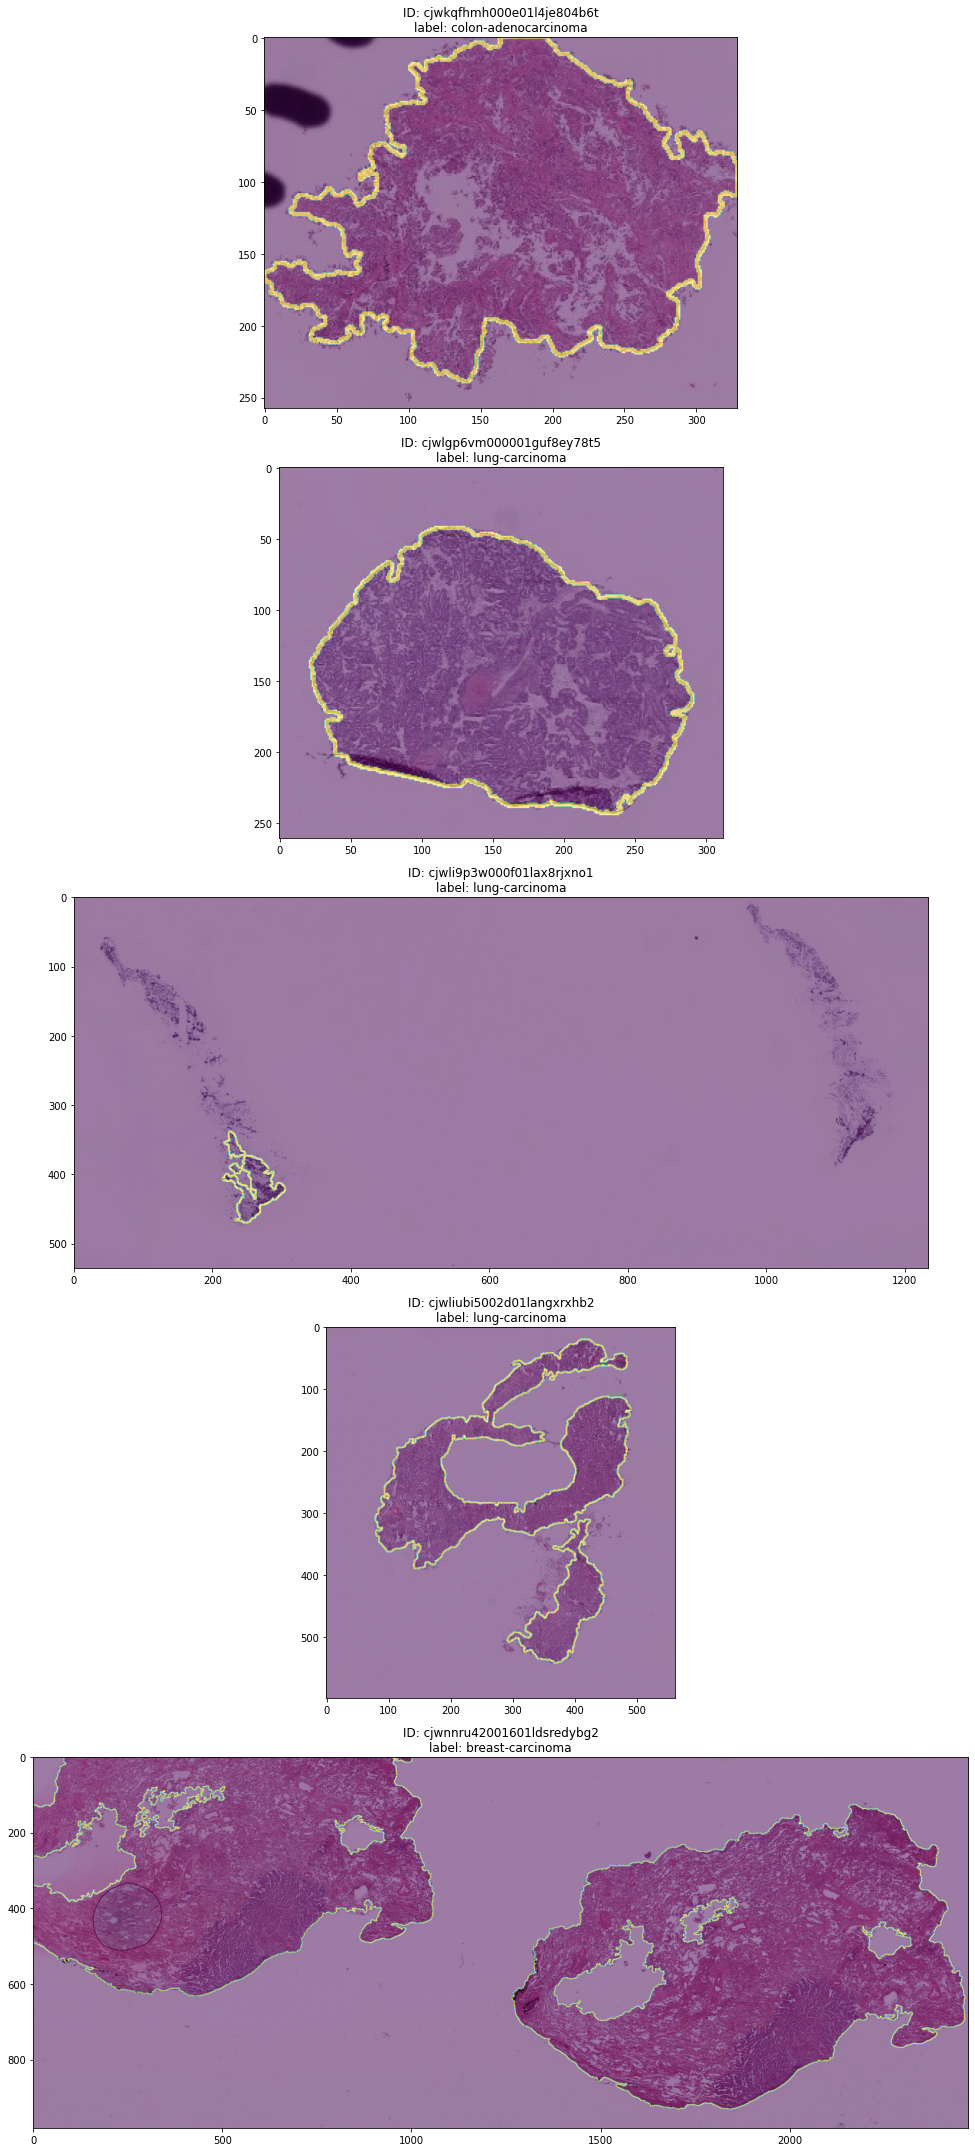

In [ ]:
display_contour_images(carcinoma_dir, car_filenames, location0, 4000)

#Display the obtained contour of non-plastic images with sensitivity of 4000

wsi.level_downsamples (1.0, 2.000083984251858, 4.0003221051451625, 8.000644210290325, 16.00128842058065, 32.01422220307741, 64.11463844797177)
wsi.level_dimensions ((22001, 25955), (11000, 12977), (5500, 6488), (2750, 3244), (1375, 1622), (687, 811), (343, 405))
6
wsi.level_downsamples (1.0, 2.000048823357094, 4.00036057286033, 8.00072114572066, 16.00144229144132, 32.00288458288264, 64.02308576839826, 128.04617153679652)
wsi.level_dimensions ((59170, 20483), (29585, 10241), (14792, 5120), (7396, 2560), (3698, 1280), (1849, 640), (924, 320), (462, 160))
6
wsi.level_downsamples (1.0, 2.000018592890079, 4.000037185780158, 8.000404132483645, 16.003317779056523, 32.01139825983164, 64.02279651966327, 128.04559303932655)
wsi.level_dimensions ((53785, 48524), (26892, 24262), (13446, 12131), (6723, 6065), (3361, 3032), (1680, 1516), (840, 758), (420, 379))
6
wsi.level_downsamples (1.0, 2.0000218264361793, 4.000043652872359, 8.000087305744717, 16.001571777855396, 32.00873515024458, 64.0398601398

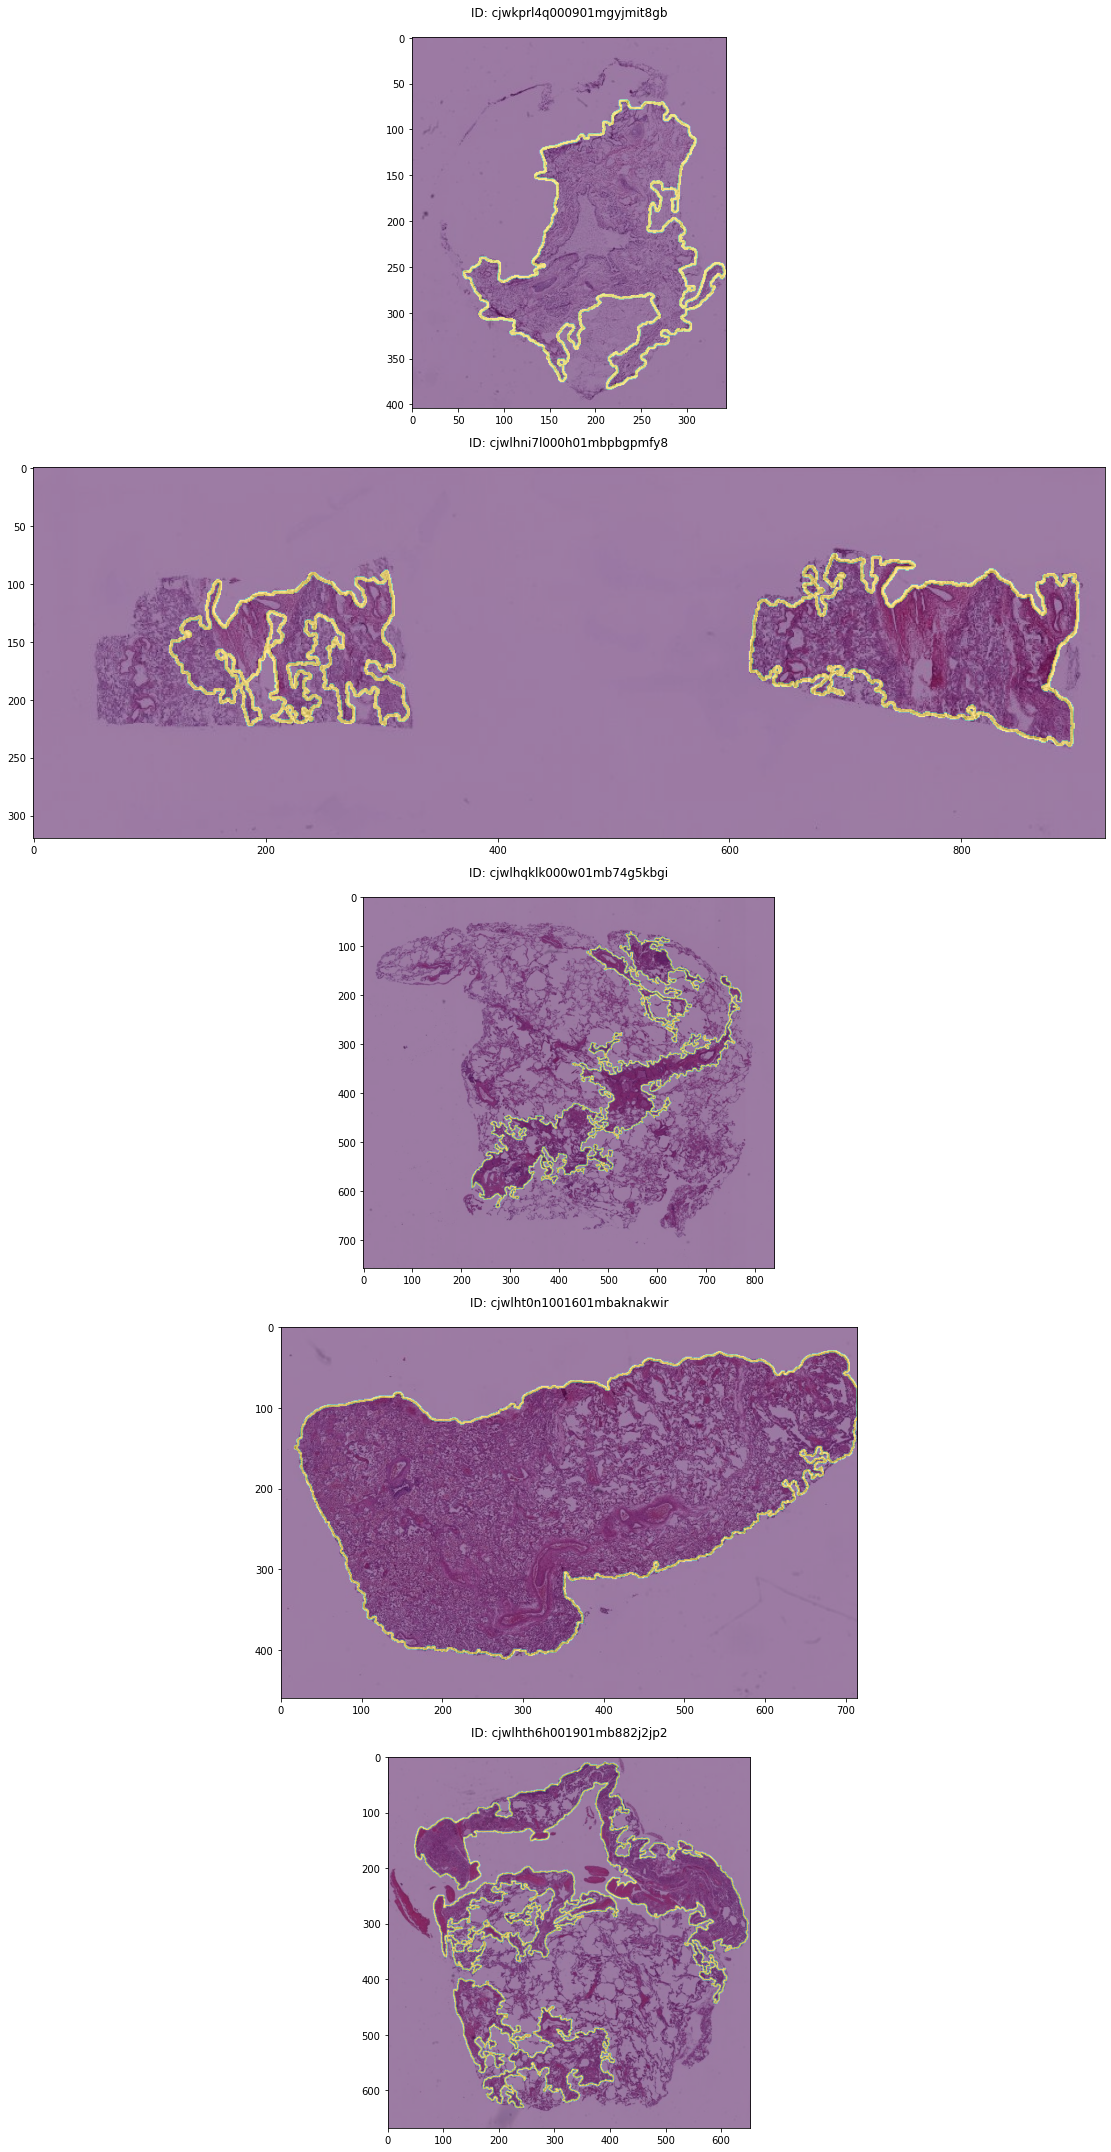

In [ ]:
display_contour_images(non_dir, non_filenames, location0, 4000)

# Functions to extract tissue contours and to split into patches
modified based on the source code of CLAM tools [CLAM](https://https://github.com/mahmoodlab/CLAM)

In [ ]:
def isInContourV3(cont, pt, patch_size=256):
    center = (pt[0]+patch_size//2, pt[1]+patch_size//2)
    all_points = [(center[0]-patch_size//4, center[1]-patch_size//4),
                  (center[0]+patch_size//4, center[1]+patch_size//4),
                  (center[0]+patch_size//4, center[1]-patch_size//4),
                  (center[0]-patch_size//4, center[1]+patch_size//4)
                  ]
    for points in all_points:
        if cv2.pointPolygonTest(cont, points, False) >= 0:
            return 1
    return 0

def isInContours(cont_check_fn, contour, pt, holes=None, patch_size=256):
    if cont_check_fn(contour, pt, patch_size):
        if holes is not None:
            return not isInHoles(holes, pt, patch_size)
        else:
            return 1
    return 0

def isInHoles(holes, pt, patch_size):
    for hole in holes:
        if cv2.pointPolygonTest(hole, (pt[0]+patch_size/2, pt[1]+patch_size/2), False) > 0:
            return 1
    return 0

#white_thresh: saturation threshold under which a patch is to be considered as blank and excluded (positive integer, default: 5)
def isWhitePatch(patch, satThresh=5):
    patch_hsv = cv2.cvtColor(patch, cv2.COLOR_RGB2HSV)
    return True if np.mean(patch_hsv[:,:,1]) < satThresh else False

#black_thresh: mean rgb threshold under which a patch is to be considered as black and excluded (positive integer, default: 50)
def isBlackPatch(patch, rgbThresh=40):
    return True if np.all(np.mean(patch, axis = (0,1)) < rgbThresh) else False

def _getPatchGenerator(name, wsi, cont, cont_idx, patch_level, save_path, patch_size, step_size, holes_tissue, 
    white_black=True, white_thresh=15, black_thresh=50):
    start_x, start_y, w, h = cv2.boundingRect(cont)
    print("Bounding Box:", start_x, start_y, w, h)
    print("Contour Area:", cv2.contourArea(cont))
    
    step_size_x,step_size_y  = step_size,step_size
    #check if the patch is in the contour
    cont_check_fn = isInContourV3

#    stop_y = start_y+h
#    stop_x = start_x+w
    img_h,img_w = wsi.level_dimensions[0]
    stop_y = min(start_y+h, img_h-patch_size)
    stop_x = min(start_x+w, img_w-patch_size)

    count = 0
    for y in range(start_y, stop_y, step_size_y):
        for x in range(start_x, stop_x, step_size_x):
            if not isInContours(cont_check_fn, cont, (x,y), holes_tissue[cont_idx], patch_size): #point not inside contour and its associated holes
                continue                
            count+=1
            patch_PIL = wsi.read_region((x,y), patch_level, (patch_size, patch_size)).convert('RGB')
            
            if white_black:
                if isBlackPatch(np.array(patch_PIL), rgbThresh=black_thresh) or isWhitePatch(np.array(patch_PIL), satThresh=white_thresh): 
                    continue

            patch_info = {'x':x, 'y':y, 'cont_idx':cont_idx, 'patch_level':patch_level, 
            'patch_PIL':patch_PIL, 'name':name, 'save_path':save_path}

            yield patch_info
   
    print("patches extracted: {}".format(count))

In [ ]:
def savePatch_to_jpg(patch, annotation, label):
    '''
    This function takes in input a patch dictionary, annotation file and the label for the patch. It then save the patch image in .jpg format,
    and add the patch information to the annotatnion file
    '''
    x, y, cont_idx, patch_level, img_patch, name, save_path= tuple(patch.values())

    patch_loc = os.path.join(save_path, name+'_x{}y{}.jpg'.format(x,y))
    if not os.path.exists(save_path):
        os.makedirs(save_path)

    img_patch.save(patch_loc)
    ann = {'image':name, 'cor':[x,y], 'cont_idx':cont_idx, 'label':label}
    annotation.append(ann)
    return annotation


In [ ]:
def _filter_contours(contours, hierarchy, filter_params):
    """
        Filter contours by: area.
    """
    filtered = []

    # find foreground contours (parent == -1)
    hierarchy_1 = np.flatnonzero(hierarchy[:,1] == -1)

    for cont_idx in hierarchy_1:
        cont = contours[cont_idx]
        a = cv2.contourArea(cont)
        if a == 0: continue
        if tuple((filter_params['a_t'],)) < tuple((a,)): 
            filtered.append(cont_idx)

    all_holes = []
    for parent in filtered:
        all_holes.append(np.flatnonzero(hierarchy[:, 1] == parent))

    foreground_contours = [contours[cont_idx] for cont_idx in filtered]
    
    hole_contours = []

    for hole_ids in all_holes:
        unfiltered_holes = [contours[idx] for idx in hole_ids ]
        unfilered_holes = sorted(unfiltered_holes, key=cv2.contourArea, reverse=True)
        unfilered_holes = unfilered_holes[:filter_params['max_n_holes']]
        filtered_holes = []
        
        for hole in unfilered_holes:
            if cv2.contourArea(hole) > filter_params['a_h']:
                filtered_holes.append(hole)

        hole_contours.append(filtered_holes)

    return foreground_contours, hole_contours

def scaleContourDim(contours, scale):
    return [np.array(cont * scale, dtype='int32') for cont in contours]

def scaleHolesDim(contours, scale):
    return [[np.array(hole * scale, dtype = 'int32') for hole in holes] for holes in contours]

def seg_patch(dir, images, filter_params, annotation, label, save_path = 'patches/', sensitivity=3000):
    '''
    Do the segmention and patching for non-plastic images
    '''
    for i, image in enumerate(images):
        print(image)
        slide = openslide.OpenSlide(os.path.join(dir, f'{image}.tiff')) # Making Openslide Object

        tissue_contours, hierarchy, downsampled_slide, downsampling_factor = detect_tissue(slide, sensitivity,64)
        hierarchy = np.squeeze(hierarchy, axis=(0,))[:,2:]

        foreground_contours, hole_contours = _filter_contours(tissue_contours, hierarchy, filter_params)

        contours = scaleContourDim(foreground_contours, downsampling_factor)
        contour_holes = scaleHolesDim(hole_contours, downsampling_factor)
        
        print("Creating patches")
       
        patch_level=0
        patch_size=256 
        step_size=256
        save_coord=True

        for idx, cont in enumerate(contours):
            patch_gen = _getPatchGenerator(image, slide, cont, idx, patch_level, save_path, patch_size, step_size, contour_holes)

            for patch in patch_gen:
                annotation = savePatch_to_jpg(patch, annotation, label)
        slide.close()

    return annotation

In [ ]:
def label_patch(dir, images, filter_params, annotation, label, save_path = 'patches/', sensitivity=3000):
    '''
    Do the segmention and patching for carcinoma images
    '''
    for i, image in enumerate(images):
        print(image)
        slide = openslide.OpenSlide(os.path.join(dir, f'{image}.tiff')) # Making Openslide Object
        with open(os.path.join(dir, f'{image}.json')) as f:
            jfile = json.load(f)
            cor = np.array([[cor['x'], cor['y']] for cor in  jfile[0]['path']])
            cor = np.clip(cor, 0, 100)
            cor[:,0], cor[:,1] = cor[:,0]*slide.dimensions[0]/100., cor[:,1]*slide.dimensions[1]/100.
        contours = cor.astype(int)       
        n,cor = contours.shape
        contours = [np.reshape(contours, (n,1,cor))]
        print(contours[0].shape)

        print("Creating patches")
        
        patch_level=0
        patch_size=256 
        step_size=256
        save_coord=True
        contour_holes = [None]

        for idx, cont in enumerate(contours):
            patch_gen = _getPatchGenerator(image, slide, cont, idx, patch_level, save_path, patch_size, step_size, contour_holes)

            for patch in patch_gen:
                annotation = savePatch_to_jpg(patch, annotation, label)
        slide.close()

    return annotation

In [ ]:
ann_train_non, ann_train_carc, ann_test_non, ann_test_carc = [],[],[],[]

In [ ]:
filter_params = {'a_t': 10, 'a_h': 16, 'max_n_holes':10}



1. a_t: area filter threshold for tissue (positive integer, the minimum size of detected foreground contours to consider, relative to a reference patch size of 512 x 512 at level 0, e.g. a value 10 means only detected foreground contours of size greater than 10 512 x 512 sized patches at level 0 will be processed, default: 100)
2. a_h: area filter threshold for holes (positive integer, the minimum size of detected holes/cavities in foreground contours to avoid, once again relative to 512 x 512 sized patches at level 0, default: 16)
3. max_n_holes: maximum of holes to consider per detected foreground contours (positive integer, default: 10, higher maximum leads to more accurate patching but increases computational cost)

#Split the dataset
Since there are only 5 images for each class: non-plastic and carcinoma, we decide to use the patches in first 4 non-plastic and 4 carcinoma images(8 totally) for training, the last non-platic and carcinoma images(2 totally) for testing

#generate training dataset for non-plastic images

In [ ]:
ann_train_non = seg_patch(non_dir, non_filenames[:4], filter_params, ann_train_non, 'non', 'patches/', 4000)

cjwkprl4q000901mgyjmit8gb
wsi.level_downsamples (1.0, 2.000083984251858, 4.0003221051451625, 8.000644210290325, 16.00128842058065, 32.01422220307741, 64.11463844797177)
wsi.level_dimensions ((22001, 25955), (11000, 12977), (5500, 6488), (2750, 3244), (1375, 1622), (687, 811), (343, 405))
6
Creating patches
Bounding Box: 3590 4488 18209 20068
Contour Area: 157468178.5
patches extracted: 2456
cjwlhni7l000h01mbpbgpmfy8
wsi.level_downsamples (1.0, 2.000048823357094, 4.00036057286033, 8.00072114572066, 16.00144229144132, 32.00288458288264, 64.02308576839826, 128.04617153679652)
wsi.level_dimensions ((59170, 20483), (29585, 10241), (14792, 5120), (7396, 2560), (3698, 1280), (1849, 640), (924, 320), (462, 160))
6
Creating patches
Bounding Box: 7554 5762 13126 8452
Contour Area: 57250282.0
patches extracted: 1017
Bounding Box: 39566 4865 18055 10501
Contour Area: 113518798.0
patches extracted: 0
cjwlhqklk000w01mb74g5kbgi
wsi.level_downsamples (1.0, 2.000018592890079, 4.000037185780158, 8.00040

In [ ]:
print('patches number for non-plastic tissues', len(ann_train_non))

patches number for non-plastic tissues 14192


# generate training dataset for carcinoma images

In [ ]:
ann_train_carc = label_patch(carcinoma_dir, car_filenames[:4], filter_params, ann_train_carc, 'carc', 'patches/', 4000)

cjwkqfhmh000e01l4je804b6t
(2886, 1, 2)
Creating patches
Bounding Box: 0 0 21104 15670
Contour Area: 198223144.5
patches extracted: 2658
cjwlgp6vm000001guf8ey78t5
(2049, 1, 2)
Creating patches
Bounding Box: 1334 2658 17313 12947
Contour Area: 158576697.5
patches extracted: 2326
cjwli9p3w000f01lax8rjxno1
(1409, 1, 2)
Creating patches
Bounding Box: 16134 26194 3541 3700
Contour Area: 5653312.0
patches extracted: 103
cjwliubi5002d01langxrxhb2
(3117, 1, 2)
Creating patches
Bounding Box: 4989 1562 26188 32994
Contour Area: 309325306.0
patches extracted: 4948


In [ ]:
print('patches number for carcinoma tissues', len(ann_train_carc))

patches number for carcinoma tissues 9530


## generate testing dataset for non-plastic images

In [ ]:
ann_test_non = seg_patch(non_dir, non_filenames[4:], filter_params, ann_test_non, 'non', 'patches_test/', 4000)

cjwlhth6h001901mb882j2jp2
wsi.level_downsamples (1.0, 2.0, 4.0, 8.0, 16.001530221882174, 32.00306044376435, 64.05457996717132, 128.20741339407076)
wsi.level_dimensions ((41832, 42784), (20916, 21392), (10458, 10696), (5229, 5348), (2614, 2674), (1307, 1337), (653, 668), (326, 334))
6
Creating patches
Bounding Box: 10953 28760 15118 11595
Contour Area: 64374445.5
patches extracted: 1124
Bounding Box: 7558 25557 8840 10827
Contour Area: 38007323.5
patches extracted: 669
Bounding Box: 6853 14348 12300 8136
Contour Area: 42882014.0
patches extracted: 754
Bounding Box: 5252 12682 21267 12300
Contour Area: 119789558.5
patches extracted: 1971
Bounding Box: 3074 704 38370 27673
Contour Area: 230441769.0
patches extracted: 3792


In [ ]:
print('patches number for test non-plastic tissues', len(ann_test_non))

patches number for test non-plastic tissues 7688


# generate training dataset for carcinoma images

In [ ]:
ann_test_carc = label_patch(carcinoma_dir, car_filenames[4:], filter_params, ann_test_carc, 'carc', 'patches_test/', 4000)

cjwnnru42001601ldsredybg2
(15260, 1, 2)
Creating patches
Bounding Box: 21034 19185 29171 21234
Contour Area: 259725904.5
patches extracted: 4156


In [ ]:
print('patches number for test carcinoma tissues', len(ann_test_carc))

patches number for test carcinoma tissues 4152


# Save the training label file and testing label file in working directory

In [ ]:
ann_train = ann_train_non + ann_train_carc
with open('train_ann.json', 'w') as f:
    json.dump(ann_train, f)

ann_test = ann_test_non + ann_test_carc
with open('test_ann.json', 'w') as f:
    json.dump(ann_test, f)

In [ ]:
print(len(ann_train), len(ann_test))

23722 11840


# Config for training

In [ ]:
enet_type = 'efficientnet-b0'
tile_size = 256
image_size = 256
Batch_size = 16
num_workers = 4
out_dim = 1
init_lr = 1e-3
n_epochs = 20

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model
use EfficientNet as the backbone, and replace the linear layer with 1 output: 0:non-plastic or 1:carcinoma

#Idea
We have only 5 images for each class, it is too small and it is difficult to train a model from scrach. So we consider to fine-tune the model with a pretrained parameter in other similar dataset

The pretrained_model parameter is obtained from the output files of a Kaggle notebook [PANDA EfficientNet-B0 Baseline](https://www.kaggle.com/haqishen/train-efficientnet-b0-w-36-tiles-256-lb0-87/output?select=how_to_train_effnet_b0_to_get_LB_0.86_best_fold0.pth)
#Put the downloaded pretrained parameter under '.tcga_assigment/' folder

In [ ]:
pretrained_model = 'tcga_assignment/how_to_train_effnet_b0_to_get_LB_0.86_best_fold0.pth'

In [ ]:
class enetv2(nn.Module):
    def __init__(self, backbone, out_dim):
        super(enetv2, self).__init__()
        self.enet = EfficientNet.from_pretrained(backbone)
        self.myFC = nn.Linear(self.enet._fc.in_features, out_dim)
        self.enet._fc = nn.Identity()

    def loadPretrainedParams(self, pretrainedParamFile):
        device=torch.device("cuda" if torch.cuda.is_available() else "cpu")

        pretrainedDict=torch.load(pretrainedParamFile,map_location=device.type)
        modelDict=self.state_dict()
        pretrainedDict = {k: v for k, v in pretrainedDict.items() if k in modelDict }
        modelDict.update(pretrainedDict)
        self.load_state_dict(modelDict)


    def extract(self, x):
        return self.enet(x)

    def forward(self, x):
        x = self.extract(x)
        x = self.myFC(x)
        return x

#Data augmentation
Because of the small dataset, data augmentatnion is applied to combat the overfitting and increase the model regularization，including rondom horizontal and vertical flip, random scale and scrop, random perspective, random translation and random rotation

In [ ]:
class Dataset(torch.utils.data.Dataset):
    """
    Create the training dataset and test dataset
    """
    def __init__(self, split='train'):
        with open('{}_ann.json'.format(split)) as f:
            self.anns=json.load(f)
        
        self.dir = 'patches' if split=='train' else 'patches_test'
        self.split = split
        self.do_augment = split=='train'
        if self.do_augment:
            #Do augmentation and scale on the data
            self.augmentation = transforms.Compose([
                    transforms.ToPILImage(),
                    transforms.RandomHorizontalFlip(p=0.5),
                    transforms.RandomVerticalFlip (p=0.5),
                    transforms.RandomResizedCrop(256, scale=(0.9, 1.0), ratio=(0.9, 1.1), interpolation=2),
                    transforms.RandomPerspective(0.2),
                    transforms.RandomAffine(degrees=0, translate=(0.1,0.1), scale=(0.9,1.1), fillcolor=0),
                    transforms.RandomRotation(90),
                    transforms.ToTensor(),
                    transforms.RandomErasing(p=0.5, scale=(0.005, 0.01), ratio=(0.5, 2.0), value=0, inplace=False),
                ])
        else:
            #Do only scale on the data
            self.norm = transforms.Compose([
                    transforms.ToPILImage(),
                    transforms.ToTensor()
                ])
        
        print('Loaded {} images for {}'.format(len(self.anns), split))

    def normalize(self, img):
        img = img[:, :, ::-1]
        img = img.transpose(2, 0, 1)
        return img

    def __getitem__(self, index):
        inp_name = os.path.join(self.dir, self.anns[index]["image"]+'_x{}y{}.jpg'.format(self.anns[index]["cor"][0], self.anns[index]["cor"][1]))
        inp = cv2.imread(inp_name)
        inp = self.normalize(inp).copy()
        inp = torch.from_numpy(inp).float()
        label = np.array([int(self.anns[index]['label'] == 'carc')]).astype(np.float)
        label = torch.from_numpy(label)
        
        if self.do_augment:
            inp = self.augmentation(inp)
        else:
            inp = self.norm(inp)        
        return inp, label

    def __len__(self):
        return len(self.anns)

In [ ]:
def create_data_loaders():
    """
    Create the training data loader and test data loader, use weightedSampling to combat data imbalance
    """
    tr_dataset, te_dataset = Dataset('train'), Dataset('test')

    train_loader = torch.utils.data.DataLoader(
        tr_dataset,
        batch_size=Batch_size,
        shuffle=True,
        drop_last=True,
        num_workers=4,
        pin_memory=True,
    )
    test_loader = torch.utils.data.DataLoader(
        te_dataset,
        batch_size=Batch_size,
        shuffle=False,
        num_workers=4,
        pin_memory=True
    )
    return train_loader, test_loader

In [ ]:
class AverageMeter(object):
    """
    Computes and stores the average and current value
    """
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
        
def step(data_loader, model, criterion, to_train=True, optimizer=None):
    """
    Used as a trining step or testing step
    """
    if to_train:
        model.train()
    else:
        model.eval()
    nIters = len(data_loader)
    loss_meter = AverageMeter()
    with tqdm(total=nIters) as t:
        predictList = []
        labelsList = []
        for i, (input_, label) in enumerate(data_loader):
            input_cuda = input_.float().cuda() if torch.cuda.is_available() else input_.float().cpu()
            label_t_cuda = label.cuda() if torch.cuda.is_available() else label.cpu()
            # ===================forward=====================
            output= model(input_cuda)
            loss = criterion(output, label_t_cuda)
            predicted = (output>0).float()
            predictList.extend(predicted.cpu().numpy().tolist())
            labelsList.extend(label_t_cuda.cpu().numpy().tolist())
            # ===================backward====================                  
            if to_train:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            loss_meter.update(loss.data.cpu().numpy())
            t.set_postfix(loss='{:10.8f}'.format(loss_meter.avg))
            t.update()
        accuracy = accuracy_score(labelsList, predictList)

    return loss_meter.avg, accuracy

def train_net(train_loader, test_loader, model, criterion, optimizer, n_epochs):
    """
    To train the model with the input arguments, and save the plot of training and testing loss and accuracy, model parameters as well
    """
    loss_tr_list, loss_val_list, acc_tr_list, acc_val_list = [], [], [], []
    for epoch in range(1,n_epochs+1):
        print('epoch',epoch)

        # ===================training====================
        loss_tr_avg, acc_tr_avg = step(train_loader, model, criterion, True, optimizer)
        # ===================validation====================
        with torch.no_grad():
            loss_val_avg, acc_val_avg = step(test_loader, model, criterion, False, optimizer)
        acc_tr_list.append(acc_tr_avg)
        acc_val_list.append(acc_val_avg)
        # ===================paramsSaving====================
        torch.save(model.state_dict(), os.path.join('epoch{}loss{}acc{}.pth'.format(epoch,loss_val_avg,acc_val_avg))) 

            
        loss_tr_list.append(loss_tr_avg)
        loss_val_list.append(loss_val_avg)
        # ===================lossAccuracyPlotting====================

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), sharex=True)
        ax1.plot(loss_tr_list, label='trainLoss')
        ax1.plot(loss_val_list, label='valLoss')
        ax1.legend(loc='upper left')

        ax2.plot(acc_tr_list, label='trainAcc')
        ax2.plot(acc_val_list, label='valAcc')
        ax2.legend(loc='upper left')
#            fig.tight_layout()

        plt.savefig(os.path.join('epoch{}.jpg'.format(epoch)))
        plt.close('all')
                              
        print('\n')

In [ ]:
# Create data loaders
train_loader, test_loader = create_data_loaders()

# Create nn
model = enetv2(enet_type, out_dim).to(device)
model.loadPretrainedParams(pretrained_model)

# Create loss criterion
criterion = nn.BCEWithLogitsLoss()

# Create optimizer
optimizer = torch.optim.Adam(model.parameters(), init_lr)

Loaded 23722 images for train
Loaded 11840 images for test


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/checkpoints/efficientnet-b0-355c32eb.pth



Loaded pretrained weights for efficientnet-b0


## Start training
Model parameter and loss&accuracy plot will be saved in the working directory after every epoch

In [ ]:
# to train the model
train_net(train_loader, test_loader, model, criterion, optimizer, n_epochs)

Loaded 23722 images for train
Loaded 11840 images for test
Loaded pretrained weights for efficientnet-b0


  0%|          | 0/1482 [00:00<?, ?it/s]

epoch 1


  0%|          | 0/1482 [00:00<?, ?it/s]



epoch 2


  0%|          | 0/1482 [00:00<?, ?it/s]



epoch 3


  0%|          | 0/1482 [00:00<?, ?it/s]



epoch 4


  0%|          | 0/1482 [00:00<?, ?it/s]



epoch 5


  0%|          | 0/1482 [00:00<?, ?it/s]



epoch 6


  0%|          | 0/1482 [00:00<?, ?it/s]



epoch 7


  0%|          | 0/1482 [00:00<?, ?it/s]



epoch 8


  0%|          | 0/1482 [00:00<?, ?it/s]



epoch 9


  0%|          | 0/1482 [00:00<?, ?it/s]



epoch 10


  0%|          | 0/1482 [00:00<?, ?it/s]



epoch 11


  0%|          | 0/1482 [00:00<?, ?it/s]



epoch 12


  0%|          | 0/1482 [00:00<?, ?it/s]



epoch 13


  0%|          | 0/1482 [00:00<?, ?it/s]



epoch 14


  0%|          | 0/1482 [00:00<?, ?it/s]



epoch 15


  0%|          | 0/1482 [00:00<?, ?it/s]



epoch 16


 92%|█████████▏| 1364/1482 [07:42<00:39,  3.01it/s, loss=0.00518720]

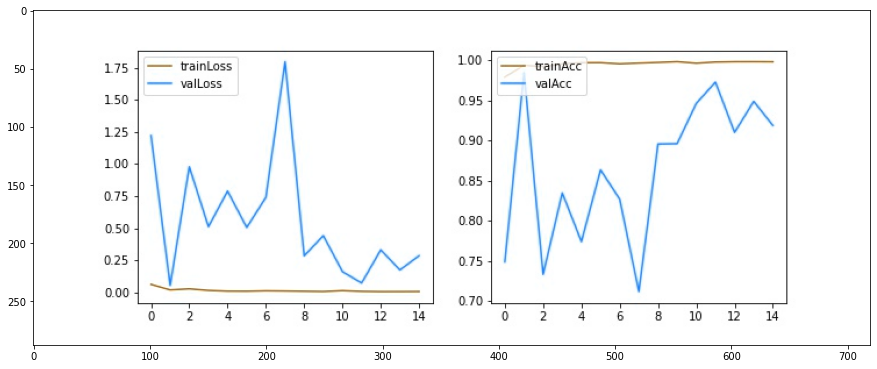

In [ ]:
loss_plot = cv2.imread('epoch15.jpg')
plt.figure(figsize=(15,20))
plt.imshow(loss_plot) 
plt.show()

#Observation
We can see that the optimal parameter is in epoch 2, then reload it for testing

#Testing on test dataset

In [ ]:
len(test_loader)

740

In [ ]:
# Test classifier
bestParam = 'epoch2loss0.05305170668242367acc0.9847128378378378.pth'
model.loadPretrainedParams(bestParam)
predictList = []
labelsList = []
model.eval()

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        predicted = (outputs>0).float()

        predictList.extend(predicted.cpu().numpy().tolist())
        labelsList.extend(labels.cpu().numpy().tolist())

## Classification report and confusion matrix are another ways to evaluate a model:

ConfusionMatrix:
[[7589   99]
 [  82 4070]]


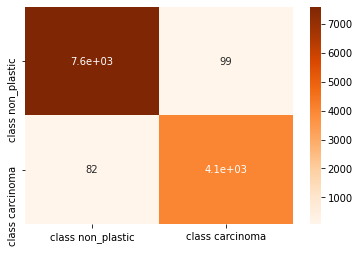

In [ ]:
confusionMatrix=confusion_matrix(labelsList, predictList)
print('ConfusionMatrix:')
np.save('confusionMatrix.npy', confusionMatrix)
print(confusionMatrix)

columns = ['class non_plastic', 'class carcinoma']
df_cm = pandas.DataFrame(confusionMatrix, index=columns, columns=columns)
ax = sn.heatmap(df_cm, cmap='Oranges', annot=True)

In [ ]:
classReport = classification_report(labelsList, predictList, digits=2)
df = pandas.DataFrame(classification_report(labelsList, predictList, digits=2, output_dict=True)).transpose()
print(classReport)

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      7688
         1.0       0.98      0.98      0.98      4152

    accuracy                           0.98     11840
   macro avg       0.98      0.98      0.98     11840
weighted avg       0.98      0.98      0.98     11840



#Thank you for reading!